<a href="https://colab.research.google.com/github/KhangVGU/embedded_anti_spoofing_stm32/blob/main/calibration_schemes/RawGAT_ST_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/eurecom-asp/RawGAT-ST-antispoofing.git

Cloning into 'RawGAT-ST-antispoofing'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 128 (delta 32), reused 84 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (128/128), 9.33 MiB | 22.48 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [1]:
%cd /content/RawGAT-ST-antispoofing
# !pip uninstall -y torch torchaudio numpy scipy
!pip install torch==2.2.0 torchaudio==2.2.0 numpy==1.23.5 scipy==1.10.1
!pip install --upgrade soundfile onnx onnxscript onnxruntime

/content/RawGAT-ST-antispoofing
  Using cached onnx-1.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.9 kB)
  Using cached onnxscript-0.3.2-py3-none-any.whl.metadata (13 kB)
  Using cached onnxruntime-1.22.1-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (4.6 kB)
  Using cached onnx_ir-0.1.6-py3-none-any.whl.metadata (3.5 kB)
  Using cached coloredlogs-15.0.1-py2.py3-none-any.whl.metadata (12 kB)
  Using cached humanfriendly-10.0-py2.py3-none-any.whl.metadata (9.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 667.4/667.4 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.3 MB/s eta 0:00:00


In [2]:
%cd /content/
!bash -c "wget -q https://www.dropbox.com/sh/gf3zp00qvdp3row/AABc-QK2BvzEPj-s8nBwCkMna/temp/asvspoof2021/toy_example.tar.gz && \
tar -xzf toy_example.tar.gz"


/content


In [ ]:
%cd /content/RawGAT-ST-antispoofing
# Colab: single-file inference for RawGAT_ST on a .flac audio
# Requirements
# !pip -q install torch torchaudio soundfile

import os
import math
import numpy as np
import soundfile as sf
import torch
import torch.nn.functional as F
import torchaudio

from model import RawGAT_ST  # uses your uploaded model.py

# ==== User inputs ====
AUDIO_PATH = "/content/toy_example/eval/LA_E_1066571.flac"            # <-- set your .flac path
MODEL_CKPT = "/content/RawGAT-ST-antispoofing/Pre_trained_models/RawGAT_ST_mul/Best_epoch.pth"           # <-- set your trained weights .pth, or leave as None
TARGET_SR  = 16000
FIXED_LEN  = 64600                              # model expects exactly this many samples (pad or crop)

# ==== Minimal model config matching model.py expectations ====
# These defaults are chosen to be consistent with the model’s forward-shape logic.
# If you trained with a different YAML, adjust values here to match your training config.
# d_args = {
#     "in_channels": 1,
#     "out_channels": 70,   # number of Sinc filters; model comments assume 70
#     "first_conv": 129,    # kernel size chosen so that 64600 -> 64472 after conv1d (no padding)
#     # Residual stacks keep channel size at 64 to match GAT input dims used in model.py
#     # Modified filts to match the checkpoint's expected channel sizes (32 instead of 64)
#     "filts": [32, [32, 32], [32, 64], [64, 64]],
# }
d_args = {
    "nb_samp": 64600,
    "out_channels": 70,
    "first_conv": 128,  # no. of filter coefficients
    "in_channels": 1,
    "filts": [32, [32, 32], [32, 64], [64, 64]],
    "blocks": [2, 4],
    "nb_classes": 2,
}

# ==== Utilities ====
def pad_or_crop(x: np.ndarray, max_len: int = FIXED_LEN) -> np.ndarray:
    """Pad by tiling or crop to fixed length, consistent with main.py::pad()."""
    x = x.astype(np.float32)
    x_len = x.shape[0]
    if x_len >= max_len:
        return x[:max_len]
    # tile to reach max_len
    num_repeats = int(max_len / x_len) + 1
    padded = np.tile(x, num_repeats)[:max_len]
    return padded

def load_audio_fixed_length(path: str, target_sr: int = TARGET_SR, fixed_len: int = FIXED_LEN) -> np.ndarray:
    wav, sr = sf.read(path, dtype="float32", always_2d=False)
    if wav.ndim > 1:
        # convert to mono
        wav = np.mean(wav, axis=1).astype(np.float32)
    if sr != target_sr:
        # resample with torchaudio for numerical stability
        wav_t = torch.from_numpy(wav).unsqueeze(0)  # shape [1, n]
        wav_rs = torchaudio.functional.resample(wav_t, orig_freq=sr, new_freq=target_sr)
        wav = wav_rs.squeeze(0).numpy()
    # normalize to prevent clipping extremes
    if np.max(np.abs(wav)) > 0:
        wav = wav / np.max(np.abs(wav))
    return pad_or_crop(wav, fixed_len)

# ==== Build model ====
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RawGAT_ST(d_args, device=device).to(device)
model.eval()

# Optional: load trained checkpoint
if MODEL_CKPT and os.path.isfile(MODEL_CKPT):
    state = torch.load(MODEL_CKPT, map_location=device)
    # both state-dict formats supported
    if isinstance(state, dict) and "state_dict" in state:
        state = state["state_dict"]
    model.load_state_dict(state)
    print(f"Loaded checkpoint: {MODEL_CKPT}")
else:
    if MODEL_CKPT:
        print(f"Warning: checkpoint not found at {MODEL_CKPT}. Proceeding with random weights.")

# ==== Inference on a single .flac ====
assert os.path.isfile(AUDIO_PATH), f"Audio not found: {AUDIO_PATH}"
x = load_audio_fixed_length(AUDIO_PATH, TARGET_SR, FIXED_LEN)  # np.float32 [64600]

# model expects shape [B, T] with T=64600
x_t = torch.from_numpy(x).unsqueeze(0).to(device)  # [1, 64600]

with torch.no_grad():
    logits = model(x_t, Freq_aug=False)            # [1, 2]
    probs  = F.softmax(logits, dim=1).squeeze(0).cpu().numpy()  # [2]

# By convention in your training/eval code: index 1 corresponds to bonafide
prob_spoof     = float(probs[0])
prob_bonafide  = float(probs[1])
pred_label     = "bonafide" if prob_bonafide >= 0.5 else "spoof"

print(f"File: {AUDIO_PATH}")
print(f"Probability — spoof: {prob_spoof:.4f}, bonafide: {prob_bonafide:.4f}")
print(f"Predicted label: {pred_label}")

/content/RawGAT-ST-antispoofing
Loaded checkpoint: /content/RawGAT-ST-antispoofing/Pre_trained_models/RawGAT_ST_mul/Best_epoch.pth
File: /content/toy_example/eval/LA_E_1066571.flac
Probability — spoof: 0.0000, bonafide: 1.0000
Predicted label: bonafide


In [2]:
%cd /content/RawGAT-ST-antispoofing
# --- Patch & export RawGAT_ST to ONNX safely (avoids Tensor==bool) ---

import os, io, re, importlib, json
import torch
import torch.onnx

# 1) Patch model.py to avoid "== True"/"== False" on any variable that could be a Tensor
#    and to keep boolean checks strictly Pythonic.
def patch_file(path, subs):
    with open(path, "r", encoding="utf-8") as f:
        txt = f.read()
    for pat, repl in subs:
        txt_new = re.sub(pat, repl, txt, flags=re.MULTILINE)
        txt = txt_new
    with open(path, "w", encoding="utf-8") as f:
        f.write(txt)

assert os.path.isfile("model.py"), "model.py not found in the current directory."

patches = [
    # In RawGAT_ST.forward: "if (Freq_aug==True):" -> "if Freq_aug:"
    (r"if\s*\(\s*Freq_aug\s*==\s*True\s*\)\s*:", "if Freq_aug:"),
    (r"if\s*\(\s*Freq_aug\s*==\s*False\s*\)\s*:", "if not Freq_aug:"),
    # In CONV.forward: "if (mask==True):" -> "if mask:"
    (r"if\s*\(\s*mask\s*==\s*True\s*\)\s*:", "if mask:"),
    (r"if\s*\(\s*mask\s*==\s*False\s*\)\s*:", "if not mask:"),
]
patch_file("model.py", patches)

# 2) Reload the model class
from importlib import reload
import model as model_mod
reload(model_mod)
from model import RawGAT_ST

# 3) Build model (adjust d_args to match your training config if needed)
d_args = {
    "nb_samp": 64600,
    "out_channels": 70,
    "first_conv": 128,  # no. of filter coefficients
    "in_channels": 1,
    "filts": [32, [32, 32], [32, 64], [64, 64]],
    "blocks": [2, 4],
    "nb_classes": 2,
}

device = "cuda" if torch.cuda.is_available() else "cpu"
model = RawGAT_ST(d_args, device=device).to(device)
model.eval()

# Optional: load your checkpoint
MODEL_CKPT = "/content/RawGAT-ST-antispoofing/Pre_trained_models/RawGAT_ST_mul/Best_epoch.pth"  # set your path or leave None
if MODEL_CKPT and os.path.isfile(MODEL_CKPT):
    state = torch.load(MODEL_CKPT, map_location=device)
    if isinstance(state, dict) and "state_dict" in state:
        state = state["state_dict"]
    model.load_state_dict(state)
    print(f"Loaded checkpoint: {MODEL_CKPT}")

# 4) Sanity forward with a fixed-length dummy input (your training uses 64600 samples)
dummy_input = torch.randn(1, 64600, dtype=torch.float32, device=device)
with torch.no_grad():
    _ = model(dummy_input, Freq_aug=False)
print("Forward pass ok.")

# 5) Export to ONNX
onnx_path = "/content/rawgat_st.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    do_constant_folding=False,   # safer when custom NumPy/Torch mixes exist
    opset_version=13,            # increase only if you need newer ops
    input_names=["input"],
    output_names=["logits"],
    dynamic_axes={"input": {1: "num_samples"}},  # allow variable-length waveforms
    training=torch.onnx.TrainingMode.EVAL,
    verbose=False
)
print(f"Exported ONNX: {onnx_path}")


/content/RawGAT-ST-antispoofing
Loaded checkpoint: /content/RawGAT-ST-antispoofing/Pre_trained_models/RawGAT_ST_mul/Best_epoch.pth
Forward pass ok.


/content/RawGAT-ST-antispoofing/model.py:375: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if Freq_aug:
/content/RawGAT-ST-antispoofing/model.py:209: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  self.band_pass[i,:]=Tensor(np.hamming(self.kernel_size))*Tensor(hideal)
/content/RawGAT-ST-antispoofing/model.py:138: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This

Exported ONNX: /content/rawgat_st.onnx


In [5]:
%cd /content/
# Colab cell: Inference with exported RawGAT_ST ONNX model
# !pip -q install onnxruntime soundfile torchaudio

import onnxruntime as ort
import numpy as np
import soundfile as sf
import torchaudio
import torch

# ==== User settings ====
ONNX_PATH   = "/content/rawgat_st.onnx"   # exported ONNX model path
AUDIO_PATH  = "/content/toy_example/eval/LA_E_1066571.flac"     # path to .flac file for inference
TARGET_SR   = 16000
FIXED_LEN   = 64600   # must match training/inference padding in your original PyTorch code

# ==== Utility functions ====
def pad_or_crop(x: np.ndarray, max_len: int = FIXED_LEN) -> np.ndarray:
    """Pad by tiling or crop to fixed length."""
    x = x.astype(np.float32)
    x_len = x.shape[0]
    if x_len >= max_len:
        return x[:max_len]
    num_repeats = int(max_len / x_len) + 1
    return np.tile(x, num_repeats)[:max_len]

def load_audio_fixed_length(path: str, target_sr: int, fixed_len: int) -> np.ndarray:
    """Load audio, convert to mono, resample, normalize, and pad/crop."""
    wav, sr = sf.read(path, dtype="float32", always_2d=False)
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)
    if sr != target_sr:
        wav_t = torch.from_numpy(wav).unsqueeze(0)
        wav_rs = torchaudio.functional.resample(wav_t, orig_freq=sr, new_freq=target_sr)
        wav = wav_rs.squeeze(0).numpy()
    if np.max(np.abs(wav)) > 0:
        wav = wav / np.max(np.abs(wav))
    return pad_or_crop(wav, fixed_len)

# ==== Load ONNX model ====
session = ort.InferenceSession(ONNX_PATH, providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# ==== Prepare input ====
x = load_audio_fixed_length(AUDIO_PATH, TARGET_SR, FIXED_LEN)
x = np.expand_dims(x, axis=0).astype(np.float32)  # shape [1, 64600]

# ==== Run inference ====
logits = session.run([output_name], {input_name: x})[0]  # shape [1, 2]
probs = torch.softmax(torch.from_numpy(logits), dim=1).numpy()[0]

prob_spoof = float(probs[0])
prob_bonafide = float(probs[1])
pred_label = "bonafide" if prob_bonafide >= 0.5 else "spoof"

print(f"File: {AUDIO_PATH}")
print(f"Probability — spoof: {prob_spoof:.4f}, bonafide: {prob_bonafide:.4f}")
print(f"Predicted label: {pred_label}")


/content
File: /content/toy_example/eval/LA_E_1066571.flac
Probability — spoof: 0.0000, bonafide: 1.0000
Predicted label: bonafide


In [3]:
%cd /content/
!python -m onnxruntime.quantization.preprocess --input rawgat_st.onnx --output rawgat_optimized.onnx --skip_symbolic_shape True


/content


In [4]:
# Colab cell: static quantization for 1D audio ONNX with correct input rank
# !pip -q install onnx onnxruntime onnxruntime-tools soundfile torchaudio

import os, glob, numpy as np, soundfile as sf, torch, torchaudio, onnx
import onnxruntime as ort
from onnxruntime.quantization import (
    quantize, QuantType, QuantFormat, StaticQuantConfig,
    CalibrationMethod, CalibrationDataReader
)

ONNX_FP32 = "/content/rawgat_optimized.onnx"           # your exported model
ONNX_INT8 = "/content/rawgat_st_int8.onnx"
CALIB_DIR = "/content/toy_example/train_dev"               # folder with a few .flac samples
TARGET_SR  = 16000
FIXED_LEN  = 64600

# 1) Inspect model I/O
sess = ort.InferenceSession(ONNX_FP32, providers=["CPUExecutionProvider"])
inp = sess.get_inputs()[0]
input_name = inp.name
print("Input name:", input_name)
print("Input type:", inp.type)
print("Input shape (may contain None for dynamic):", inp.shape)

# 2) Audio preprocessing that matches your PyTorch inference
def pad_or_crop(x: np.ndarray, L: int) -> np.ndarray:
    x = x.astype(np.float32)
    if x.shape[0] >= L:
        return x[:L]
    reps = int(L / x.shape[0]) + 1
    return np.tile(x, reps)[:L]

def load_audio_fixed_length(path: str, target_sr: int, fixed_len: int) -> np.ndarray:
    wav, sr = sf.read(path, dtype="float32", always_2d=False)
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)
    if sr != target_sr:
        wav_t = torch.from_numpy(wav).unsqueeze(0)
        wav_rs = torchaudio.functional.resample(wav_t, orig_freq=sr, new_freq=target_sr)
        wav = wav_rs.squeeze(0).numpy()
    m = np.max(np.abs(wav))
    if m > 0:
        wav = wav / m
    return pad_or_crop(wav, fixed_len)

# 3) CalibrationDataReader that yields rank-2 input: [1, num_samples]
class FixedLengthAudioReader(CalibrationDataReader):
    def __init__(self, audio_folder: str, input_name: str, target_sr: int = 16000, fixed_len: int = 64600):
        self.input_name = input_name
        self.files = sorted([p for p in glob.glob(os.path.join(audio_folder, "*.flac"))])
        self.target_sr = target_sr
        self.fixed_len = fixed_len
        self._iter = iter(self.files)

    def get_next(self):
        try:
            p = next(self._iter)
        except StopIteration:
            return None
        x = load_audio_fixed_length(p, self.target_sr, self.fixed_len)      # shape [L]
        x = np.expand_dims(x.astype(np.float32), axis=0)                     # shape [1, L]
        return {self.input_name: x}

# 4) Create reader
reader = FixedLengthAudioReader(CALIB_DIR, input_name, TARGET_SR, FIXED_LEN)

# 5) Static quantization configuration
# conf = StaticQuantConfig(
#     calibration_method=CalibrationMethod.Entropy,  # or MinMax, Percentile
#     activation_type=QuantType.QInt8,
#     weight_type=QuantType.QInt8,
#     quant_format=QuantFormat.QDQ,
#     per_channel=True,
#     # You can restrict ops if needed:
#     # op_types_to_quantize=["Conv", "MatMul", "Gemm"]
# )
conf = StaticQuantConfig(
    calibration_data_reader=reader,
    quant_format=QuantFormat.QDQ,
    calibrate_method=CalibrationMethod.MinMax,
    # calibration_providers='CUDAExecutionProvider',
    # optimize_model=True, # Removed unsupported argument
    activation_type=QuantType.QUInt8,
    weight_type=QuantType.QInt8,
    per_channel=True,
    extra_options={"ActivationSymmetric":False,
                  "WeightSymmetric":True}
)

# 6) Run quantization
quantize(
    model_input=ONNX_FP32,
    model_output=ONNX_INT8,
    quant_config=conf
    # calibration_data_reader=reader
)
print(f"Quantized model saved to {ONNX_INT8}")

# 7) Sanity check a forward pass on the quantized model
qsess = ort.InferenceSession(ONNX_INT8, providers=["CPUExecutionProvider"])
x = np.random.randn(1, FIXED_LEN).astype(np.float32)
_ = qsess.run([qsess.get_outputs()[0].name], {input_name: x})
print("Quantized model inference ok.")


Input name: input
Input type: tensor(float)
Input shape (may contain None for dynamic): [1, 'num_samples']


ValueError: No data is collected.

In [13]:
%cd /content/
# Colab cell: Inference with exported RawGAT_ST ONNX model
# !pip -q install onnxruntime soundfile torchaudio

import onnxruntime as ort
import numpy as np
import soundfile as sf
import torchaudio
import torch

# ==== User settings ====
ONNX_PATH   = "/content/rawgat_st_int8.onnx"   # exported ONNX model path
AUDIO_PATH  = "/content/toy_example/eval/LA_E_1066571.flac"     # path to .flac file for inference
TARGET_SR   = 16000
FIXED_LEN   = 64600   # must match training/inference padding in your original PyTorch code

# ==== Utility functions ====
def pad_or_crop(x: np.ndarray, max_len: int = FIXED_LEN) -> np.ndarray:
    """Pad by tiling or crop to fixed length."""
    x = x.astype(np.float32)
    x_len = x.shape[0]
    if x_len >= max_len:
        return x[:max_len]
    num_repeats = int(max_len / x_len) + 1
    return np.tile(x, num_repeats)[:max_len]

def load_audio_fixed_length(path: str, target_sr: int, fixed_len: int) -> np.ndarray:
    """Load audio, convert to mono, resample, normalize, and pad/crop."""
    wav, sr = sf.read(path, dtype="float32", always_2d=False)
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)
    if sr != target_sr:
        wav_t = torch.from_numpy(wav).unsqueeze(0)
        wav_rs = torchaudio.functional.resample(wav_t, orig_freq=sr, new_freq=target_sr)
        wav = wav_rs.squeeze(0).numpy()
    if np.max(np.abs(wav)) > 0:
        wav = wav / np.max(np.abs(wav))
    return pad_or_crop(wav, fixed_len)

# ==== Load ONNX model ====
session = ort.InferenceSession(ONNX_PATH, providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

# ==== Prepare input ====
x = load_audio_fixed_length(AUDIO_PATH, TARGET_SR, FIXED_LEN)
x = np.expand_dims(x, axis=0).astype(np.float32)  # shape [1, 64600]

# ==== Run inference ====
logits = session.run([output_name], {input_name: x})[0]  # shape [1, 2]
probs = torch.softmax(torch.from_numpy(logits), dim=1).numpy()[0]

prob_spoof = float(probs[0])
prob_bonafide = float(probs[1])
pred_label = "bonafide" if prob_bonafide >= 0.5 else "spoof"

print(f"File: {AUDIO_PATH}")
print(f"Probability — spoof: {prob_spoof:.4f}, bonafide: {prob_bonafide:.4f}")
print(f"Predicted label: {pred_label}")


/content
File: /content/toy_example/eval/LA_E_1066571.flac
Probability — spoof: 0.1298, bonafide: 0.8702
Predicted label: bonafide


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Colab cell: static quantization for 1D audio ONNX with correct input rank
# !pip -q install onnx onnxruntime onnxruntime-tools soundfile torchaudio

import os, glob, numpy as np, soundfile as sf, torch, torchaudio, onnx
import onnxruntime as ort
from onnxruntime.quantization import (
    quantize, QuantType, QuantFormat, StaticQuantConfig,
    CalibrationMethod, CalibrationDataReader
)

ONNX_FP32 = "/content/rawgat_optimized.onnx"           # your exported model
ONNX_INT8 = "/content/rawgat_int8_scheme_9.onnx"
CALIB_DIR = "/content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/Calibration_9_filtered"               # folder with a few .flac samples
TARGET_SR  = 16000
FIXED_LEN  = 64600

# 1) Inspect model I/O
sess = ort.InferenceSession(ONNX_FP32, providers=["CPUExecutionProvider"])
inp = sess.get_inputs()[0]
input_name = inp.name
print("Input name:", input_name)
print("Input type:", inp.type)
print("Input shape (may contain None for dynamic):", inp.shape)

# 2) Audio preprocessing that matches your PyTorch inference
def pad_or_crop(x: np.ndarray, L: int) -> np.ndarray:
    x = x.astype(np.float32)
    if x.shape[0] >= L:
        return x[:L]
    reps = int(L / x.shape[0]) + 1
    return np.tile(x, reps)[:L]

def load_audio_fixed_length(path: str, target_sr: int, fixed_len: int) -> np.ndarray:
    wav, sr = sf.read(path, dtype="float32", always_2d=False)
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)
    if sr != target_sr:
        wav_t = torch.from_numpy(wav).unsqueeze(0)
        wav_rs = torchaudio.functional.resample(wav_t, orig_freq=sr, new_freq=target_sr)
        wav = wav_rs.squeeze(0).numpy()
    m = np.max(np.abs(wav))
    if m > 0:
        wav = wav / m
    return pad_or_crop(wav, fixed_len)

# 3) CalibrationDataReader that yields rank-2 input: [1, num_samples]
class FixedLengthAudioReader(CalibrationDataReader):
    def __init__(self, audio_folder: str, input_name: str, target_sr: int = 16000, fixed_len: int = 64600):
        self.input_name = input_name
        self.files = sorted([p for p in glob.glob(os.path.join(audio_folder, "*.flac"))])
        self.target_sr = target_sr
        self.fixed_len = fixed_len
        self._iter = iter(self.files)

    def get_next(self):
        try:
            p = next(self._iter)
        except StopIteration:
            return None
        x = load_audio_fixed_length(p, self.target_sr, self.fixed_len)      # shape [L]
        x = np.expand_dims(x.astype(np.float32), axis=0)                     # shape [1, L]
        return {self.input_name: x}

# 4) Create reader
reader = FixedLengthAudioReader(CALIB_DIR, input_name, TARGET_SR, FIXED_LEN)

# 5) Static quantization configuration
# conf = StaticQuantConfig(
#     calibration_method=CalibrationMethod.Entropy,  # or MinMax, Percentile
#     activation_type=QuantType.QInt8,
#     weight_type=QuantType.QInt8,
#     quant_format=QuantFormat.QDQ,
#     per_channel=True,
#     # You can restrict ops if needed:
#     # op_types_to_quantize=["Conv", "MatMul", "Gemm"]
# )
conf = StaticQuantConfig(
    calibration_data_reader=reader,
    quant_format=QuantFormat.QDQ,
    calibrate_method=CalibrationMethod.MinMax,
    # calibration_providers='CUDAExecutionProvider',
    # optimize_model=True, # Removed unsupported argument
    activation_type=QuantType.QUInt8,
    weight_type=QuantType.QInt8,
    per_channel=True,
    extra_options={"ActivationSymmetric":False,
                  "WeightSymmetric":True}
)

# 6) Run quantization
quantize(
    model_input=ONNX_FP32,
    model_output=ONNX_INT8,
    quant_config=conf
    # calibration_data_reader=reader
)
print(f"Quantized model saved to {ONNX_INT8}")

Input name: input
Input type: tensor(float)
Input shape (may contain None for dynamic): [1, 'num_samples']


Quantized model saved to /content/rawgat_int8_scheme_9.onnx


In [8]:
%cd /content/RawGAT-ST-antispoofing/
!python evaluate_rawgat.py \
    --onnx_model_path /content/rawgat_st.onnx \
    --audio_folder /content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/Evaluation_500_unique_to_all_calibrations \
    --save_plot /content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/rawgat_orignial.png \
    --protocol_path /content/drive/MyDrive/Scientific_Projects/University_of_Stuttgart/ASVSpoof_Datasets/2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt


/content/RawGAT-ST-antispoofing

------------------------------------------------------------
Evaluated 500 files.
TP=421, TN=65, FP=0, FN=14
Accuracy: 0.9720
FPR: 0.0000   FNR: 0.0322   EER: 0.0161
Confusion matrix saved to: /content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/rawgat_orignial.png


In [9]:
%cd /content/RawGAT-ST-antispoofing/
!python evaluate_rawgat.py \
    --onnx_model_path /content/rawgat_int8_scheme_9.onnx \
    --audio_folder /content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/Evaluation_500_unique_to_all_calibrations \
    --save_plot /content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/rawgat_scheme9.png \
    --protocol_path /content/drive/MyDrive/Scientific_Projects/University_of_Stuttgart/ASVSpoof_Datasets/2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt


/content/RawGAT-ST-antispoofing

------------------------------------------------------------
Evaluated 500 files.
TP=435, TN=0, FP=65, FN=0
Accuracy: 0.8700
FPR: 1.0000   FNR: 0.0000   EER: 0.5000
Confusion matrix saved to: /content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/rawgat_scheme9.png


Total files: 118  |  Buckets: 8  |  Device: cuda
Collected features shape: (118, 70)


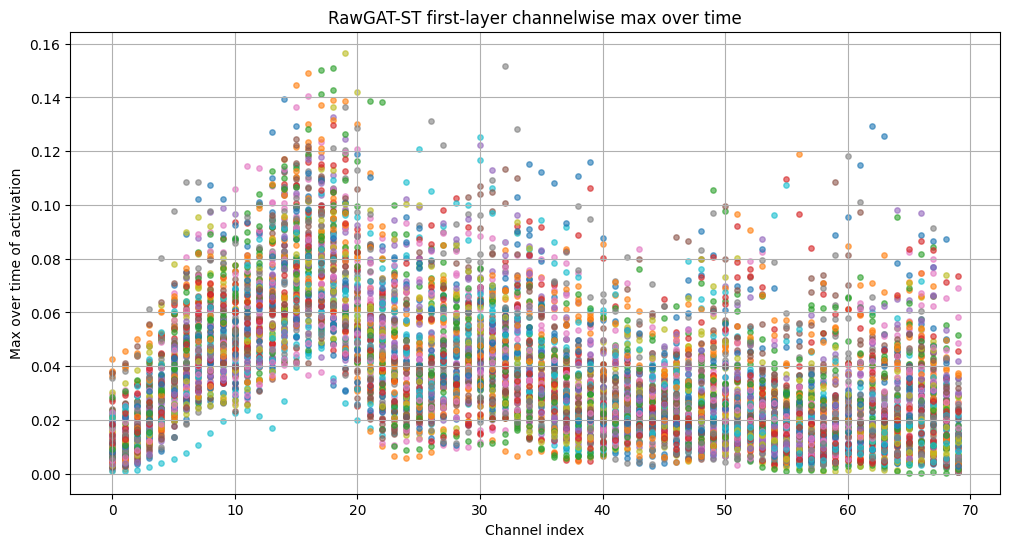

In [25]:
# ============================================
# RawGAT (model.py) — First layer max-over-time per channel, for a folder
# ============================================

# 0) Optional installs
# !pip -q install soundfile scipy matplotlib

import os
import math
import json
import numpy as np
import torch
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import resample
from typing import List, Tuple

from model import RawGAT_ST  # requires model.py in current directory

# 1) Paths
AUDIO_FOLDER       = "/content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/Calibration_14_RawGAT"   # folder with .flac files
CHECKPOINT_PATH    = "/content/RawGAT-ST-antispoofing/Pre_trained_models/RawGAT_ST_mul/Best_epoch.pth"         # your RawGAT weights (.pth) or set to None
SAVE_CSV           = False
CSV_PATH           = "/content/first_layer_channelwise_max_rawgat.csv"

# 2) Options
SAMPLE_RATE        = 16000
BATCH_SIZE_MAX     = 16         # micro-batch size
BUCKET_TOL         = 2.0        # files in a bucket have length within 2x
PER_FILE_MASK      = False      # True = independent freq mask per file when Freq_aug=True
FREQ_AUG_FLAG      = False      # keep False for analysis; set True to enable conv masking
NORMALIZE_PER_FILE = False      # True = L2-normalize each vector before plotting
SHOW_LEGEND        = False      # enable only when few files

# 3) RawGAT d_args (adjust to match your training config)
d_args = {
    "nb_samp": 64600,
    "out_channels": 70,
    "first_conv": 128,  # no. of filter coefficients
    "in_channels": 1,
    "filts": [32, [32, 32], [32, 64], [64, 64]],
    "blocks": [2, 4],
    "nb_classes": 2,
}

# 4) Utilities
def load_audio(path: str, target_sr: int = 16000) -> np.ndarray:
    wav, sr = sf.read(path, dtype="float32", always_2d=False)
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    if sr != target_sr:
        num = int(len(wav) * float(target_sr) / sr)
        wav = resample(wav, num).astype(np.float32)
    return wav.astype(np.float32)

def list_flacs_with_lengths(folder: str) -> List[Tuple[str, int]]:
    files = [f for f in os.listdir(folder) if f.lower().endswith(".flac")]
    files.sort()
    out = []
    for f in files:
        try:
            info = sf.info(os.path.join(folder, f))
            out.append((f, int(info.frames)))
        except Exception:
            wav = load_audio(os.path.join(folder, f), SAMPLE_RATE)
            out.append((f, len(wav)))
    out.sort(key=lambda x: x[1])
    return out

def conv1d_out_len(L: int, k: int, s: int = 1, p: int = 0, d: int = 1) -> int:
    return math.floor((L + 2*p - d*(k - 1) - 1)/s + 1)

# 5) Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RawGAT_ST(d_args, device=device).to(device)
if CHECKPOINT_PATH and os.path.isfile(CHECKPOINT_PATH):
    ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
    state = ckpt.get("state_dict", ckpt)
    model.load_state_dict(state, strict=False)
model.eval()
torch.set_grad_enabled(False)

# Effective kernel of first conv (RawGAT forces odd)
first_conv_cfg = int(d_args["first_conv"])
first_conv_eff = first_conv_cfg if first_conv_cfg % 2 == 1 else first_conv_cfg + 1

# 6) Build length buckets
pairs = list_flacs_with_lengths(AUDIO_FOLDER)
if not pairs:
    raise RuntimeError("No .flac files found in AUDIO_FOLDER")

batches = []
bucket = []
bucket_min = None
for fname, L in pairs:
    if not bucket:
        bucket = [(fname, L)]
        bucket_min = L
        continue
    if len(bucket) < BATCH_SIZE_MAX and L <= bucket_min * BUCKET_TOL:
        bucket.append((fname, L))
    else:
        batches.append(bucket)
        bucket = [(fname, L)]
        bucket_min = L
if bucket:
    batches.append(bucket)

print(f"Total files: {len(pairs)}  |  Buckets: {len(batches)}  |  Device: {device}")

# 7) Run first-layer conv and collect per-file channelwise maxima over time
all_names = []
all_vecs  = []  # each is [C_out]

with torch.no_grad():
    for b_idx, bucket in enumerate(batches, start=1):
        names = [x[0] for x in bucket]
        wavs  = [load_audio(os.path.join(AUDIO_FOLDER, nm), SAMPLE_RATE) for nm in names]
        max_len = max(len(w) for w in wavs)
        padded = [np.pad(w, (0, max_len - len(w))) if len(w) < max_len else w for w in wavs]
        x = torch.from_numpy(np.stack(padded)).unsqueeze(1).to(device)  # [B, 1, T_pad]
        B_local = x.shape[0]

        # Forward first conv; optional independent masking per file
        if PER_FILE_MASK and FREQ_AUG_FLAG:
            ys = []
            for i in range(B_local):
                ys.append(model.conv_time(x[i:i+1], mask=True))   # [1, C_out, T_out_pad]
            y = torch.cat(ys, dim=0)
        else:
            y = model.conv_time(x, mask=bool(FREQ_AUG_FLAG))      # [B, C_out, T_out_pad]

        _, C_out, T_out_pad = y.shape
        T_out_true = [max(0, conv1d_out_len(len(w), first_conv_eff, 1, 0, 1)) for w in wavs]

        for i, nm in enumerate(names):
            Tt = T_out_true[i]
            if Tt > 0:
                m = y[i, :, :Tt].abs().max(dim=1).values          # channelwise max over valid time
            else:
                m = torch.zeros(C_out, device=y.device)
            vec = m.detach().cpu().numpy()
            if NORMALIZE_PER_FILE:
                denom = np.linalg.norm(vec) + 1e-12
                vec = vec / denom
            all_names.append(nm)
            all_vecs.append(vec)

features = np.stack(all_vecs, axis=0)  # [N_files, C_out]
N_files, C_out = features.shape
print(f"Collected features shape: {features.shape}")

# 8) Plot
plt.figure(figsize=(12, 6))
x_axis = np.arange(C_out)
for i in range(N_files):
    plt.scatter(x_axis, features[i], s=15, alpha=0.6)
plt.title("RawGAT-ST first-layer channelwise max over time")
plt.xlabel("Channel index")
plt.ylabel("Max over time of activation")
plt.grid(True)
if SHOW_LEGEND and N_files <= 20:
    plt.legend([os.path.basename(n) for n in all_names], fontsize=8)
plt.show()

# 9) Optional CSV
if SAVE_CSV:
    import csv
    with open(CSV_PATH, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["filename"] + [f"ch_{c}" for c in range(C_out)])
        for nm, row in zip(all_names, features):
            writer.writerow([nm] + list(map(float, row)))
    print(f"Saved CSV to {CSV_PATH}")


Total files: 500  |  Buckets: 32  |  Device: cuda
Collected features shape: (500, 70)


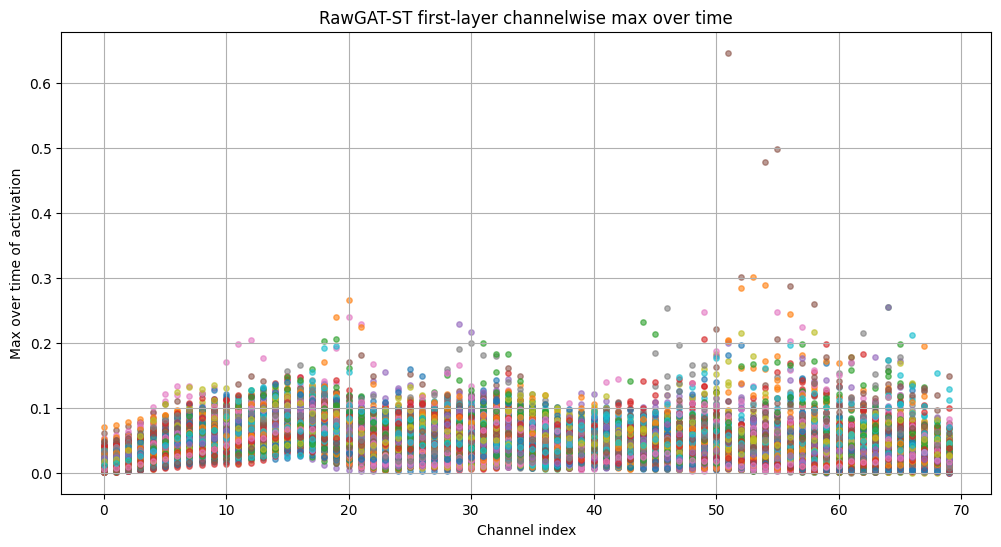

In [12]:
# ============================================
# RawGAT (model.py) — First layer max-over-time per channel, for a folder
# ============================================

# 0) Optional installs
# !pip -q install soundfile scipy matplotlib

import os
import math
import json
import numpy as np
import torch
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import resample
from typing import List, Tuple

from model import RawGAT_ST  # requires model.py in current directory

# 1) Paths
AUDIO_FOLDER       = "/content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/Evaluation_500_unique_to_all_calibrations"   # folder with .flac files
CHECKPOINT_PATH    = "/content/RawGAT-ST-antispoofing/Pre_trained_models/RawGAT_ST_mul/Best_epoch.pth"         # your RawGAT weights (.pth) or set to None
SAVE_CSV           = False
CSV_PATH           = "/content/first_layer_channelwise_max_rawgat.csv"

# 2) Options
SAMPLE_RATE        = 16000
BATCH_SIZE_MAX     = 16         # micro-batch size
BUCKET_TOL         = 2.0        # files in a bucket have length within 2x
PER_FILE_MASK      = False      # True = independent freq mask per file when Freq_aug=True
FREQ_AUG_FLAG      = False      # keep False for analysis; set True to enable conv masking
NORMALIZE_PER_FILE = False      # True = L2-normalize each vector before plotting
SHOW_LEGEND        = False      # enable only when few files

# 3) RawGAT d_args (adjust to match your training config)
d_args = {
    "nb_samp": 64600,
    "out_channels": 70,
    "first_conv": 128,  # no. of filter coefficients
    "in_channels": 1,
    "filts": [32, [32, 32], [32, 64], [64, 64]],
    "blocks": [2, 4],
    "nb_classes": 2,
}

# 4) Utilities
def load_audio(path: str, target_sr: int = 16000) -> np.ndarray:
    wav, sr = sf.read(path, dtype="float32", always_2d=False)
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    if sr != target_sr:
        num = int(len(wav) * float(target_sr) / sr)
        wav = resample(wav, num).astype(np.float32)
    return wav.astype(np.float32)

def list_flacs_with_lengths(folder: str) -> List[Tuple[str, int]]:
    files = [f for f in os.listdir(folder) if f.lower().endswith(".flac")]
    files.sort()
    out = []
    for f in files:
        try:
            info = sf.info(os.path.join(folder, f))
            out.append((f, int(info.frames)))
        except Exception:
            wav = load_audio(os.path.join(folder, f), SAMPLE_RATE)
            out.append((f, len(wav)))
    out.sort(key=lambda x: x[1])
    return out

def conv1d_out_len(L: int, k: int, s: int = 1, p: int = 0, d: int = 1) -> int:
    return math.floor((L + 2*p - d*(k - 1) - 1)/s + 1)

# 5) Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RawGAT_ST(d_args, device=device).to(device)
if CHECKPOINT_PATH and os.path.isfile(CHECKPOINT_PATH):
    ckpt = torch.load(CHECKPOINT_PATH, map_location=device)
    state = ckpt.get("state_dict", ckpt)
    model.load_state_dict(state, strict=False)
model.eval()
torch.set_grad_enabled(False)

# Effective kernel of first conv (RawGAT forces odd)
first_conv_cfg = int(d_args["first_conv"])
first_conv_eff = first_conv_cfg if first_conv_cfg % 2 == 1 else first_conv_cfg + 1

# 6) Build length buckets
pairs = list_flacs_with_lengths(AUDIO_FOLDER)
if not pairs:
    raise RuntimeError("No .flac files found in AUDIO_FOLDER")

batches = []
bucket = []
bucket_min = None
for fname, L in pairs:
    if not bucket:
        bucket = [(fname, L)]
        bucket_min = L
        continue
    if len(bucket) < BATCH_SIZE_MAX and L <= bucket_min * BUCKET_TOL:
        bucket.append((fname, L))
    else:
        batches.append(bucket)
        bucket = [(fname, L)]
        bucket_min = L
if bucket:
    batches.append(bucket)

print(f"Total files: {len(pairs)}  |  Buckets: {len(batches)}  |  Device: {device}")

# 7) Run first-layer conv and collect per-file channelwise maxima over time
all_names = []
all_vecs  = []  # each is [C_out]

with torch.no_grad():
    for b_idx, bucket in enumerate(batches, start=1):
        names = [x[0] for x in bucket]
        wavs  = [load_audio(os.path.join(AUDIO_FOLDER, nm), SAMPLE_RATE) for nm in names]
        max_len = max(len(w) for w in wavs)
        padded = [np.pad(w, (0, max_len - len(w))) if len(w) < max_len else w for w in wavs]
        x = torch.from_numpy(np.stack(padded)).unsqueeze(1).to(device)  # [B, 1, T_pad]
        B_local = x.shape[0]

        # Forward first conv; optional independent masking per file
        if PER_FILE_MASK and FREQ_AUG_FLAG:
            ys = []
            for i in range(B_local):
                ys.append(model.conv_time(x[i:i+1], mask=True))   # [1, C_out, T_out_pad]
            y = torch.cat(ys, dim=0)
        else:
            y = model.conv_time(x, mask=bool(FREQ_AUG_FLAG))      # [B, C_out, T_out_pad]

        _, C_out, T_out_pad = y.shape
        T_out_true = [max(0, conv1d_out_len(len(w), first_conv_eff, 1, 0, 1)) for w in wavs]

        for i, nm in enumerate(names):
            Tt = T_out_true[i]
            if Tt > 0:
                m = y[i, :, :Tt].abs().max(dim=1).values          # channelwise max over valid time
            else:
                m = torch.zeros(C_out, device=y.device)
            vec = m.detach().cpu().numpy()
            if NORMALIZE_PER_FILE:
                denom = np.linalg.norm(vec) + 1e-12
                vec = vec / denom
            all_names.append(nm)
            all_vecs.append(vec)

features = np.stack(all_vecs, axis=0)  # [N_files, C_out]
N_files, C_out = features.shape
print(f"Collected features shape: {features.shape}")

# 8) Plot
plt.figure(figsize=(12, 6))
x_axis = np.arange(C_out)
for i in range(N_files):
    plt.scatter(x_axis, features[i], s=15, alpha=0.6)
plt.title("RawGAT-ST first-layer channelwise max over time")
plt.xlabel("Channel index")
plt.ylabel("Max over time of activation")
plt.grid(True)
if SHOW_LEGEND and N_files <= 20:
    plt.legend([os.path.basename(n) for n in all_names], fontsize=8)
plt.show()

# 9) Optional CSV
if SAVE_CSV:
    import csv
    with open(CSV_PATH, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["filename"] + [f"ch_{c}" for c in range(C_out)])
        for nm, row in zip(all_names, features):
            writer.writerow([nm] + list(map(float, row)))
    print(f"Saved CSV to {CSV_PATH}")

Reference files: 280  |  Buckets: 18  |  Device: cuda
Reference feature matrix: (280, 70)
Euclidean threshold (pctl 99.9): 0.444440
Mahalanobis threshold (pctl 99.9): 14.257624
Channelwise z-score threshold: 4.00


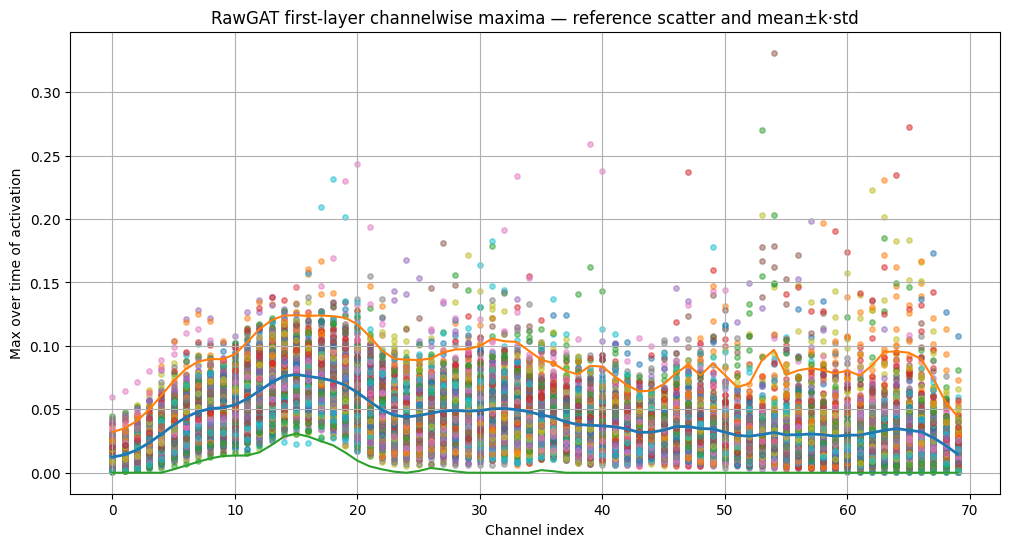


Screening 140 file(s) from NEW_AUDIO/NEW_FOLDER
- LA_D_1002130.flac -> OUTLIER | z_any_gt=True  eucl=0.2410 ( thr=0.4444)mahal=16.1962 (> thr=14.2576)
- LA_D_1017803.flac -> OK | z_any_gt=False  eucl=0.1809 ( thr=0.4444)mahal=6.1223 ( thr=14.2576)
- LA_D_1263173.flac -> OK | z_any_gt=False  eucl=0.1666 ( thr=0.4444)mahal=11.3085 ( thr=14.2576)
- LA_D_1459930.flac -> OK | z_any_gt=False  eucl=0.1428 ( thr=0.4444)mahal=9.0314 ( thr=14.2576)
- LA_D_1521999.flac -> OK | z_any_gt=False  eucl=0.1396 ( thr=0.4444)mahal=3.8642 ( thr=14.2576)
- LA_D_1543746.flac -> OUTLIER | z_any_gt=True  eucl=0.2736 ( thr=0.4444)mahal=23.2572 (> thr=14.2576)
- LA_D_1609520.flac -> OK | z_any_gt=False  eucl=0.1663 ( thr=0.4444)mahal=7.8673 ( thr=14.2576)
- LA_D_1720015.flac -> OK | z_any_gt=False  eucl=0.1719 ( thr=0.4444)mahal=7.7941 ( thr=14.2576)
- LA_D_1732752.flac -> OK | z_any_gt=False  eucl=0.1707 ( thr=0.4444)mahal=7.4164 ( thr=14.2576)
- LA_D_1976246.flac -> OK | z_any_gt=False  eucl=0.1695 ( thr=0.4

In [23]:
# ============================================
# RawGAT (model.py) — Calibration data filter via first-layer maxima
# ============================================

# Optional installs
# !pip -q install soundfile scipy matplotlib

import os
import math
import shutil
import numpy as np
import torch
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import resample
from typing import List, Tuple

from model import RawGAT_ST  # requires model.py in the working directory

# 1) Paths
AUDIO_FOLDER   = "/content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/Calibration_6_combined_cal2_cal5"  # reference set to fit thresholds
CHECKPOINT_PTH = "/content/RawGAT-ST-antispoofing/Pre_trained_models/RawGAT_ST_mul/Best_epoch.pth"               # RawGAT weights (.pth); set None to skip load
NEW_AUDIO      = None                                   # e.g. "/content/new.wav"
NEW_FOLDER     = "/content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/Calibration_3_train_20_each"  # folder to screen
OK_FOLDER      = "/content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/Calibration_14_RawGAT"   # where OK files are copied

os.makedirs(OK_FOLDER, exist_ok=True)

# 2) Options
SAMPLE_RATE        = 16000
BATCH_SIZE_MAX     = 16
BUCKET_TOL         = 2.0
PER_FILE_MASK      = False        # True = independent frequency mask per file when freq augmentation is enabled
FREQ_AUG_FLAG      = False        # keep False for analysis
NORMALIZE_PER_FILE = False        # L2-normalize channelwise vector before scoring
SHOW_LEGEND        = False
K_STD_LINE         = 2.0          # overlay mean ± K*std lines on the scatter plot

# Anomaly thresholds
Z_THRESH     = 4.0                # any channel z-score above this flags as outlier
EUCL_PCTL    = 99.9               # Euclidean distance percentile threshold
MAHAL_PCTL   = 99.9               # Mahalanobis distance percentile threshold
MAHAL_RIDGE  = 1e-6               # covariance ridge regularizer

# 3) RawGAT configuration — adjust to match training
d_args = {
    "nb_samp": 64600,
    "out_channels": 70,
    "first_conv": 128,  # no. of filter coefficients
    "in_channels": 1,
    "filts": [32, [32, 32], [32, 64], [64, 64]],
    "blocks": [2, 4],
    "nb_classes": 2,
}

# ---------- Utilities ----------
def load_audio(path: str, target_sr: int = 16000) -> np.ndarray:
    wav, sr = sf.read(path, dtype="float32", always_2d=False)
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    if sr != target_sr:
        num = int(len(wav) * float(target_sr) / sr)
        wav = resample(wav, num).astype(np.float32)
    return wav.astype(np.float32)

def list_wavs_with_lengths(folder: str) -> List[Tuple[str, int]]:
    files = [f for f in os.listdir(folder) if f.lower().endswith((".flac", ".wav"))]
    files.sort()
    out = []
    for f in files:
        fpath = os.path.join(folder, f)
        try:
            info = sf.info(fpath)
            out.append((f, int(info.frames)))
        except Exception:
            wav = load_audio(fpath, SAMPLE_RATE)
            out.append((f, len(wav)))
    out.sort(key=lambda x: x[1])
    return out

def conv1d_out_len(L: int, k: int, s: int = 1, p: int = 0, d: int = 1) -> int:
    return math.floor((L + 2*p - d*(k - 1) - 1)/s + 1)

def compute_first_layer(model, x, freq_aug_flag: bool):
    return model.conv_time(x, mask=freq_aug_flag)

def channelwise_max_vector(y_sample: torch.Tensor, T_true: int, use_abs: bool = True):
    if T_true <= 0:
        return torch.zeros(y_sample.shape[0], device=y_sample.device)
    z = y_sample[:, :T_true]
    if use_abs:
        z = z.abs()
    return z.max(dim=1).values

def l2_normalize(v: np.ndarray, eps: float = 1e-12):
    n = np.linalg.norm(v)
    return v / (n + eps)

def mahalanobis(x: np.ndarray, mean: np.ndarray, cov_inv: np.ndarray) -> float:
    d = x - mean
    return float(d.T @ cov_inv @ d) ** 0.5

def cov_inverse(X: np.ndarray, ridge: float = 1e-6):
    mu = X.mean(axis=0, keepdims=True)
    Z = X - mu
    C = (Z.T @ Z) / max(1, X.shape[0] - 1)  # unbiased covariance
    C += ridge * np.eye(C.shape[0], dtype=C.dtype)
    return np.linalg.pinv(C)

# ---------- Load model ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RawGAT_ST(d_args, device=device).to(device)
if CHECKPOINT_PTH and os.path.isfile(CHECKPOINT_PTH):
    ckpt = torch.load(CHECKPOINT_PTH, map_location=device)
    state = ckpt.get("state_dict", ckpt)
    model.load_state_dict(state, strict=False)
model.eval()
torch.set_grad_enabled(False)

# Effective first conv kernel size
first_conv_cfg = int(d_args["first_conv"])
first_conv_eff = first_conv_cfg if first_conv_cfg % 2 == 1 else first_conv_cfg + 1

# ---------- Build reference feature matrix ----------
pairs = list_wavs_with_lengths(AUDIO_FOLDER)
if not pairs:
    raise RuntimeError("No .flac or .wav files found in AUDIO_FOLDER")

# Bucketing by length to limit padding
batches, bucket, bucket_min = [], [], None
for fname, L in pairs:
    if not bucket:
        bucket, bucket_min = [(fname, L)], L
        continue
    if len(bucket) < BATCH_SIZE_MAX and L <= bucket_min * BUCKET_TOL:
        bucket.append((fname, L))
    else:
        batches.append(bucket)
        bucket, bucket_min = [(fname, L)], L
if bucket:
    batches.append(bucket)

print(f"Reference files: {len(pairs)}  |  Buckets: {len(batches)}  |  Device: {device}")

file_names_ref, feats_ref = [], []

with torch.no_grad():
    for bucket in batches:
        names = [x[0] for x in bucket]
        wavs  = [load_audio(os.path.join(AUDIO_FOLDER, nm), SAMPLE_RATE) for nm in names]
        max_len = max(len(w) for w in wavs)
        padded = [np.pad(w, (0, max_len - len(w))) if len(w) < max_len else w for w in wavs]
        x = torch.from_numpy(np.stack(padded)).unsqueeze(1).to(device)  # [B,1,T]
        B_local = x.shape[0]

        if PER_FILE_MASK and FREQ_AUG_FLAG:
            ys = []
            for i in range(B_local):
                ys.append(compute_first_layer(model, x[i:i+1], True))
            y = torch.cat(ys, dim=0)
        else:
            y = compute_first_layer(model, x, bool(FREQ_AUG_FLAG))  # [B,C_out,T_out]

        _, C_out, _ = y.shape
        T_out_true = [max(0, conv1d_out_len(len(w), first_conv_eff, 1, 0, 1)) for w in wavs]

        for i, nm in enumerate(names):
            vec = channelwise_max_vector(y[i], T_out_true[i], use_abs=True).detach().cpu().numpy()
            if NORMALIZE_PER_FILE:
                vec = l2_normalize(vec)
            file_names_ref.append(nm)
            feats_ref.append(vec)

features = np.stack(feats_ref, axis=0)  # [N_ref, C_out]
N_ref, C_out = features.shape
print(f"Reference feature matrix: {features.shape}")

# ---------- Reference statistics and thresholds ----------
mu = features.mean(axis=0)             # [C_out]
sigma = features.std(axis=0, ddof=1)   # [C_out]
sigma = np.maximum(sigma, 1e-12)

# Euclidean threshold
ref_eucl = np.linalg.norm(features - mu[None, :], axis=1)
eucl_thresh = float(np.percentile(ref_eucl, EUCL_PCTL))

# Mahalanobis threshold
cov_inv = cov_inverse(features, ridge=MAHAL_RIDGE)
ref_mahal = np.array([mahalanobis(x, mu, cov_inv) for x in features])
mahal_thresh = float(np.percentile(ref_mahal, MAHAL_PCTL))

print(f"Euclidean threshold (pctl {EUCL_PCTL}): {eucl_thresh:.6f}")
print(f"Mahalanobis threshold (pctl {MAHAL_PCTL}): {mahal_thresh:.6f}")
print(f"Channelwise z-score threshold: {Z_THRESH:.2f}")

# ---------- Visualization of reference set ----------
plt.figure(figsize=(12, 6))
x_axis = np.arange(C_out)
for i in range(N_ref):
    plt.scatter(x_axis, features[i], s=15, alpha=0.5)
plt.plot(x_axis, mu, linewidth=2.0, label="mean")
if K_STD_LINE and K_STD_LINE > 0:
    upper = mu + K_STD_LINE * sigma
    lower = np.clip(mu - K_STD_LINE * sigma, a_min=0, a_max=None)
    plt.plot(x_axis, upper, linewidth=1.5, label=f"mean + {K_STD_LINE}·std")
    plt.plot(x_axis, lower, linewidth=1.5, label=f"mean - {K_STD_LINE}·std (clipped)")
plt.title("RawGAT first-layer channelwise maxima — reference scatter and mean±k·std")
plt.xlabel("Channel index")
plt.ylabel("Max over time of activation")
plt.grid(True)
if SHOW_LEGEND:
    plt.legend()
plt.show()

# ---------- Scoring helpers ----------
def score_vector(vec: np.ndarray):
    v = l2_normalize(vec) if NORMALIZE_PER_FILE else vec.copy()
    z = (v - mu) / sigma
    z_flag = bool(np.any(z > Z_THRESH))
    eucl = float(np.linalg.norm(v - mu))
    mahal = float(mahalanobis(v, mu, cov_inv))
    return {
        "z_any_gt_thresh": z_flag,
        "euclidean": eucl,
        "euclidean_is_outlier": bool(eucl > eucl_thresh),
        "mahalanobis": mahal,
        "mahalanobis_is_outlier": bool(mahal > mahal_thresh),
    }

def extract_vec_for_path(p: str) -> np.ndarray:
    wav = load_audio(p, SAMPLE_RATE)
    T_in = len(wav)
    x = torch.from_numpy(wav).unsqueeze(0).unsqueeze(1).to(device)  # [1,1,T]
    y = compute_first_layer(model, x, bool(FREQ_AUG_FLAG))         # [1,C_out,T_out]
    T_true = max(0, conv1d_out_len(T_in, first_conv_eff, 1, 0, 1))
    vec = channelwise_max_vector(y[0], T_true, use_abs=True).detach().cpu().numpy()
    if NORMALIZE_PER_FILE:
        vec = l2_normalize(vec)
    return vec

# ---------- Build list of new items to screen ----------
new_paths = []
if isinstance(NEW_AUDIO, str) and os.path.isfile(NEW_AUDIO):
    new_paths.append(NEW_AUDIO)
if isinstance(NEW_FOLDER, str) and os.path.isdir(NEW_FOLDER):
    new_paths.extend([os.path.join(NEW_FOLDER, f)
                      for f in os.listdir(NEW_FOLDER)
                      if f.lower().endswith((".flac", ".wav"))])

# ---------- Screen and copy OK files ----------
if new_paths:
    print(f"\nScreening {len(new_paths)} file(s) from NEW_AUDIO/NEW_FOLDER")
    kept, rejected = 0, 0
    for p in sorted(new_paths):
        try:
            vec = extract_vec_for_path(p)
            dec = score_vector(vec)
            is_outlier = dec["z_any_gt_thresh"] or dec["euclidean_is_outlier"] or dec["mahalanobis_is_outlier"]
            status = "OUTLIER" if is_outlier else "OK"
            print(f"- {os.path.basename(p)} -> {status} | "
                  f"z_any_gt={dec['z_any_gt_thresh']}  eucl={dec['euclidean']:.4f} "
                  # f"({'>': dec['euclidean_is_outlier']} thr={eucl_thresh:.4f})  "
                  f"({'>' if dec['euclidean_is_outlier'] else ''} thr={eucl_thresh:.4f})"
                  # f"mahal={dec['mahalanobis']:.4f} ({'>': dec['mahalanobis_is_outlier']} thr={mahal_thresh:.4f})")
                  f"mahal={dec['mahalanobis']:.4f} ({'>' if dec['mahalanobis_is_outlier'] else ''} thr={mahal_thresh:.4f})")
            if not is_outlier:
                shutil.copy2(p, os.path.join(OK_FOLDER, os.path.basename(p)))
                kept += 1
            else:
                rejected += 1
        except Exception as e:
            print(f"  Error processing {p}: {e}")
    print(f"\nCompleted. Kept: {kept}  Rejected: {rejected}  Copied OK files to: {OK_FOLDER}")
else:
    print("\nNo NEW_AUDIO or NEW_FOLDER provided. Only reference analysis was performed.")


In [26]:
# Colab cell: static quantization for 1D audio ONNX with correct input rank
# !pip -q install onnx onnxruntime onnxruntime-tools soundfile torchaudio

import os, glob, numpy as np, soundfile as sf, torch, torchaudio, onnx
import onnxruntime as ort
from onnxruntime.quantization import (
    quantize, QuantType, QuantFormat, StaticQuantConfig,
    CalibrationMethod, CalibrationDataReader
)

ONNX_FP32 = "/content/rawgat_optimized.onnx"           # your exported model
ONNX_INT8 = "/content/rawgat_int8_scheme_14.onnx"
CALIB_DIR = "/content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/Calibration_14_RawGAT"               # folder with a few .flac samples
TARGET_SR  = 16000
FIXED_LEN  = 64600

# 1) Inspect model I/O
sess = ort.InferenceSession(ONNX_FP32, providers=["CPUExecutionProvider"])
inp = sess.get_inputs()[0]
input_name = inp.name
print("Input name:", input_name)
print("Input type:", inp.type)
print("Input shape (may contain None for dynamic):", inp.shape)

# 2) Audio preprocessing that matches your PyTorch inference
def pad_or_crop(x: np.ndarray, L: int) -> np.ndarray:
    x = x.astype(np.float32)
    if x.shape[0] >= L:
        return x[:L]
    reps = int(L / x.shape[0]) + 1
    return np.tile(x, reps)[:L]

def load_audio_fixed_length(path: str, target_sr: int, fixed_len: int) -> np.ndarray:
    wav, sr = sf.read(path, dtype="float32", always_2d=False)
    if wav.ndim > 1:
        wav = np.mean(wav, axis=1)
    if sr != target_sr:
        wav_t = torch.from_numpy(wav).unsqueeze(0)
        wav_rs = torchaudio.functional.resample(wav_t, orig_freq=sr, new_freq=target_sr)
        wav = wav_rs.squeeze(0).numpy()
    m = np.max(np.abs(wav))
    if m > 0:
        wav = wav / m
    return pad_or_crop(wav, fixed_len)

# 3) CalibrationDataReader that yields rank-2 input: [1, num_samples]
class FixedLengthAudioReader(CalibrationDataReader):
    def __init__(self, audio_folder: str, input_name: str, target_sr: int = 16000, fixed_len: int = 64600):
        self.input_name = input_name
        self.files = sorted([p for p in glob.glob(os.path.join(audio_folder, "*.flac"))])
        self.target_sr = target_sr
        self.fixed_len = fixed_len
        self._iter = iter(self.files)

    def get_next(self):
        try:
            p = next(self._iter)
        except StopIteration:
            return None
        x = load_audio_fixed_length(p, self.target_sr, self.fixed_len)      # shape [L]
        x = np.expand_dims(x.astype(np.float32), axis=0)                     # shape [1, L]
        return {self.input_name: x}

# 4) Create reader
reader = FixedLengthAudioReader(CALIB_DIR, input_name, TARGET_SR, FIXED_LEN)

# 5) Static quantization configuration
# conf = StaticQuantConfig(
#     calibration_method=CalibrationMethod.Entropy,  # or MinMax, Percentile
#     activation_type=QuantType.QInt8,
#     weight_type=QuantType.QInt8,
#     quant_format=QuantFormat.QDQ,
#     per_channel=True,
#     # You can restrict ops if needed:
#     # op_types_to_quantize=["Conv", "MatMul", "Gemm"]
# )
conf = StaticQuantConfig(
    calibration_data_reader=reader,
    quant_format=QuantFormat.QDQ,
    calibrate_method=CalibrationMethod.MinMax,
    # calibration_providers='CUDAExecutionProvider',
    # optimize_model=True, # Removed unsupported argument
    activation_type=QuantType.QUInt8,
    weight_type=QuantType.QInt8,
    per_channel=True,
    extra_options={"ActivationSymmetric":False,
                  "WeightSymmetric":True}
)

# 6) Run quantization
quantize(
    model_input=ONNX_FP32,
    model_output=ONNX_INT8,
    quant_config=conf
    # calibration_data_reader=reader
)
print(f"Quantized model saved to {ONNX_INT8}")

Input name: input
Input type: tensor(float)
Input shape (may contain None for dynamic): [1, 'num_samples']


Quantized model saved to /content/rawgat_int8_scheme_14.onnx


In [27]:
%cd /content/RawGAT-ST-antispoofing/
!python evaluate_rawgat.py \
    --onnx_model_path /content/rawgat_int8_scheme_14.onnx \
    --audio_folder /content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/Evaluation_500_unique_to_all_calibrations \
    --save_plot /content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/rawgat_scheme14.png \
    --protocol_path /content/drive/MyDrive/Scientific_Projects/University_of_Stuttgart/ASVSpoof_Datasets/2019/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt


/content/RawGAT-ST-antispoofing

------------------------------------------------------------
Evaluated 500 files.
TP=416, TN=45, FP=20, FN=19
Accuracy: 0.9220
FPR: 0.3077   FNR: 0.0437   EER: 0.1757
Confusion matrix saved to: /content/drive/MyDrive/Researches/Anti_spoofing/aasist/experiment/rawgat_scheme14.png
